# ![Feature Extraction vs Fine-Tuning](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)



In [1]:
import tensorflow as tf
import os

from helper_functions import (
    create_tensorboard_callback,
    plot_loss_curves,
    unzip_data,
    walk_through_dir,
    compare_historys,
    create_model_callbacks

)

In [2]:
print(f"[INFO] TensorFlow version: {tf.__version__}")


[INFO] TensorFlow version: 2.10.0


In [3]:
IMAGE_SHAPE = (224, 224)
INPUT_MODEL_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

# Directories
TRAIN_DIR_10_PERCENT = "data/10_food_classes_10_percent/10_food_classes_10_percent/train"
TEST_DIR_10_PERCENT = "data/10_food_classes_10_percent/10_food_classes_10_percent/test"


In [4]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR_10_PERCENT,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR_10_PERCENT,
    image_size=IMAGE_SHAPE,
    label_mode="categorical"
)

Found 750 files belonging to 10 classes.


KeyboardInterrupt: 

In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
for images, labels in train_data_10_percent.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32, 10)


In [ ]:
print(images[0])
print(labels[0])

tf.Tensor(
[[[53.540817   16.540817    7.5408163 ]
  [53.663265   15.663265    6.663265  ]
  [54.92347    16.92347     7.9234695 ]
  ...
  [23.785736   10.          1.2142639 ]
  [28.18881    11.18881     3.18881   ]
  [28.571323   11.571324    3.5713239 ]]

 [[51.83163    13.831633    2.831632  ]
  [53.08163    15.081633    4.081632  ]
  [51.158165   13.158164    2.1581635 ]
  ...
  [24.586777   10.801041    2.0153046 ]
  [27.285753   10.285753    2.2857533 ]
  [28.33156    11.33156     3.3315601 ]]

 [[54.852043   16.423468    5.6377554 ]
  [53.57143    15.142858    4.3571434 ]
  [55.32653    15.188775    5.2346935 ]
  ...
  [24.571495   10.785758    2.000022  ]
  [25.142883    8.142883    0.1428833 ]
  [27.642822   10.642822    2.6428223 ]]

 ...

 [[21.209234    8.209235    0.28061998]
  [19.19896     6.1989594   0.        ]
  [20.382614    7.382614    0.3367223 ]
  ...
  [ 4.214264    0.5968827   0.        ]
  [ 3.2703981   2.2703981   0.        ]
  [ 2.780556    1.780556    0.   

![Sample image from the dataset](https://blog.roboflow.com/content/images/2024/04/image-1085.webp)


In [14]:
from os import name

# Load EfficientNetB0 without the top classification head
print("[INFO] Loading EfficientNetB0 base model with ImageNet weights (include_top=False)...")
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_MODEL_SHAPE
)

print(f"[INFO] Base model loaded. Trainable: {base_model.trainable}")

# Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False
print("[INFO] Base model frozen (weights will not be updated during initial training).")

# Create inputs into the base model
inputs = tf.keras.layers.Input(shape=INPUT_MODEL_SHAPE, name="input_layer")

print(f"[INFO] Input layer defined: {inputs.shape}")

# If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model(inputs, training=False)  # Use training=False to freeze BN layers
print(f"[INFO] Output shape from base model: {x.shape}")

# Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"[INFO] After GlobalAveragePooling2D: {x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
print(f"[INFO] Output layer defined: {outputs.shape}")

model_0 = tf.keras.Model(inputs, outputs, name="EfficientNetB0_transfer_learning")
print("[INFO] Model assembled successfully.\n")

print("[INFO] Model summary:")
model_0.summary()

[INFO] Loading EfficientNetB0 base model with ImageNet weights (include_top=False)...
[INFO] Base model loaded. Trainable: True
[INFO] Base model frozen (weights will not be updated during initial training).
[INFO] Input layer defined: (None, 224, 224, 3)
[INFO] Output shape from base model: (None, 7, 7, 1280)
[INFO] After GlobalAveragePooling2D: (None, 1280)
[INFO] Output layer defined: (None, 10)
[INFO] Model assembled successfully.

[INFO] Model summary:
Model: "EfficientNetB0_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)       

In [ ]:
#compile the model

model_0.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


history_model_0 = model_0.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback(
        dir_name="transfer_learning",
        experiment_name="efficientnetb0_10_food_classes_10_percent_feature_extraction_5_epochs"
    ),
    *create_model_callbacks("model_0", "checkpoints")
    ]
)





Saving TensorBoard log files to: transfer_learning/efficientnetb0_10_food_classes_10_percent_feature_extraction_5_epochs/20250709-123953
Epoch 1/5


In [5]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

NameError: name 'base_model' is not defined

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
model_0.summary()

Model: "EfficientNetB0_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


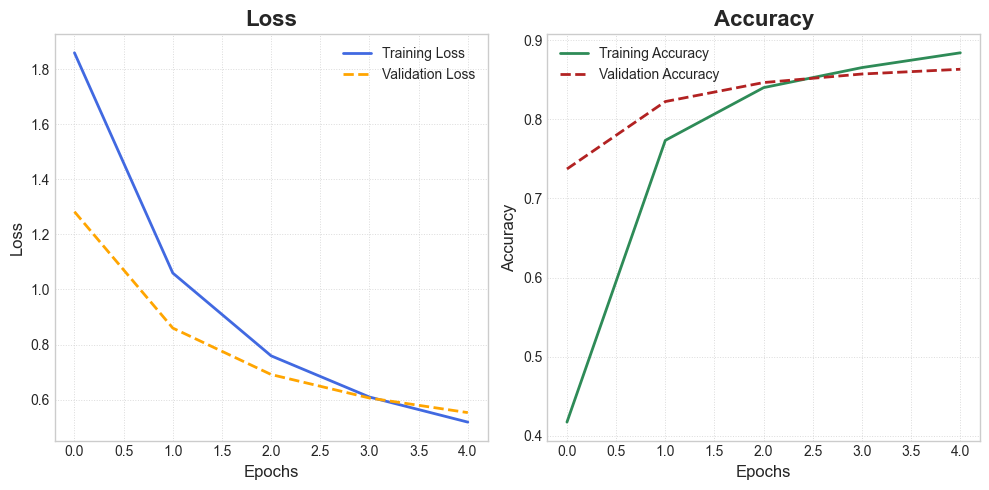

In [ ]:
plot_loss_curves(history_model_0)

In [ ]:
# Download and unzip data

data_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
data_zip_path = "data/10_food_classes_1_percent.zip"

if not os.path.exists("data/10_food_classes_1_percent"):
    if not os.path.exists(data_zip_path):
        import urllib.request
        urllib.request.urlretrieve(data_url, data_zip_path)
    unzip_data(data_zip_path)


In [ ]:
train_dir_1_percent = "data/10_food_classes_1_percent/train/"
test_dir_1_percent = "data/10_food_classes_1_percent/test/"


In [ ]:
walk_through_dir("data/10_food_classes_1_percent")

There are 2 directories and 0 images in 'data/10_food_classes_1_percent'.
There are 10 directories and 0 images in 'data/10_food_classes_1_percent\test'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in 'data/10_food_classes_1_percent\test\steak'.
There are 0 directories a

In [ ]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir_1_percent,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir_1_percent,
    image_size=IMAGE_SHAPE,
    label_mode="categorical"
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
data_augmentation_model = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
], name="data_augmentation_model")


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_MODEL_SHAPE
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=INPUT_MODEL_SHAPE, name="input_layer")
x = data_augmentation_model(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs, name="EfficientNetB0_transfer_learning_1_percent")

model_1.summary()

Model: "EfficientNetB0_transfer_learning_1_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_model (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381


In [ ]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
history_model_1 = model_1.fit(
    train_data_1_percent,
    epochs=5,
    validation_data=test_data_1_percent,
    steps_per_epoch=len(train_data_1_percent),
    validation_steps=int(0.25 * len(test_data_1_percent)),
    callbacks=[create_tensorboard_callback(
        dir_name="transfer_learning",
        experiment_name="efficientnetb0_10_food_classes_1_percent_feature_extraction"
    ),
    *create_model_callbacks("model_1", "checkpoints")
    ]
)

Saving TensorBoard log files to: transfer_learning/efficientnetb0_10_food_classes_1_percent_feature_extraction/20250709-034143
Epoch 1/5
2/3 [===================>..........] - ETA: 0s - loss: 2.3988 - accuracy: 0.1094 
Epoch 1: saving model to checkpoints\all_epochs\model_1_checkpoint.h5

Epoch 1: val_loss improved from inf to 2.23904, saving model to checkpoints\model_1_best.h5
3/3 [==============================] - 11s 2s/step - loss: 2.4195 - accuracy: 0.1000 - val_loss: 2.2390 - val_accuracy: 0.1480
Epoch 2/5
2/3 [===================>..........] - ETA: 0s - loss: 2.0882 - accuracy: 0.2656
Epoch 2: saving model to checkpoints\all_epochs\model_1_checkpoint.h5

Epoch 2: val_loss improved from 2.23904 to 2.11586, saving model to checkpoints\model_1_best.h5
3/3 [==============================] - 2s 827ms/step - loss: 2.1176 - accuracy: 0.2429 - val_loss: 2.1159 - val_accuracy: 0.2286
Epoch 3/5
2/3 [===================>..........] - ETA: 0s - loss: 1.9991 - accuracy: 0.3594
Epoch 3: savi

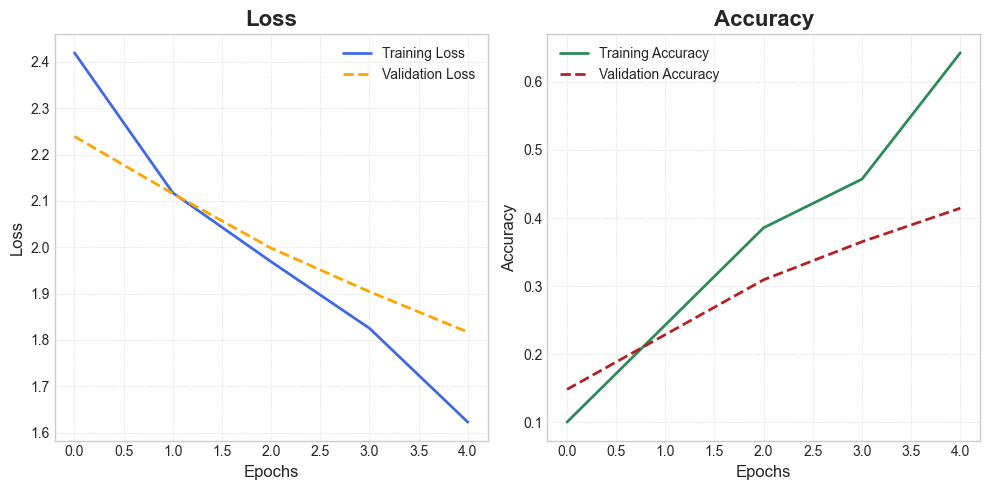

In [ ]:
plot_loss_curves(history_model_1)

In [9]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_MODEL_SHAPE
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=INPUT_MODEL_SHAPE, name="input_layer")
x = data_augmentation_model(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs, name="EfficientNetB0_transfer_learning_1_percent")

model_2.summary()

Model: "EfficientNetB0_transfer_learning_1_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_model (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381


In [10]:
model_2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


In [ ]:
history_model_2 = model_2.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    validation_steps= len(test_data_10_percent),
    callbacks=[create_tensorboard_callback(
        dir_name="transfer_learning",
        experiment_name="efficientnetb0_10_food_classes_10_percent_feature_extraction_with_data_augmentation"
    ),
    *create_model_callbacks("model_2", "checkpoints")
    ]
)

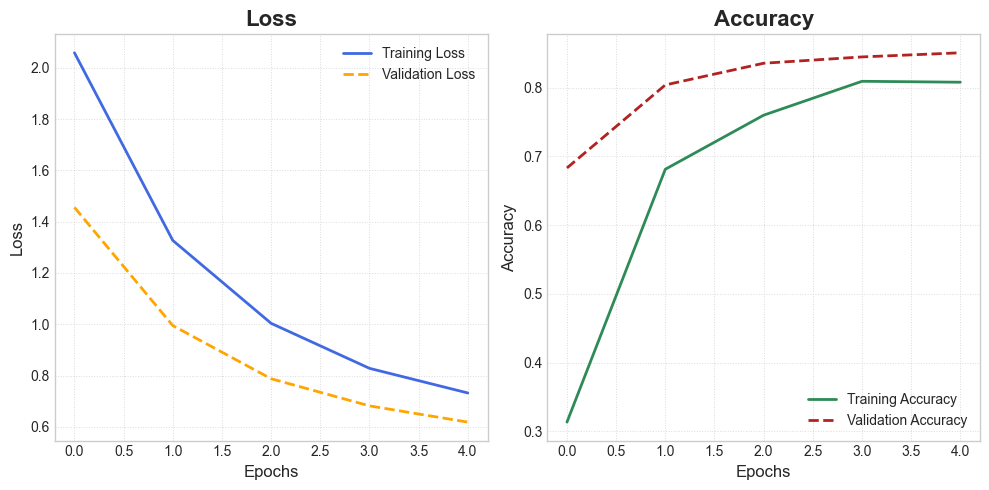

In [ ]:
plot_loss_curves(history_model_2)

In [16]:
data_url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"
data_zip_path = "data/10_food_classes_all_data.zip"
unzip_dir = "data/10_food_classes_all_data"

if not os.path.exists(unzip_dir):
    if not os.path.exists(data_zip_path):
        import urllib.request
        urllib.request.urlretrieve(data_url, data_zip_path)
    unzip_data(data_zip_path, extract_dir=unzip_dir)

In [17]:
TRAIN_DIR_FULL = "data/10_food_classes_all_data/10_food_classes_all_data/train"
TEST_DIR_FULL = "data/10_food_classes_all_data/10_food_classes_all_data/test"

In [19]:
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR_FULL,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)


test_data_full=tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR_FULL,
    image_size=IMAGE_SHAPE,
    label_mode="categorical"
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [20]:
model_2.load_weights("checkpoints/all_epochs/model_2_checkpoint.h5")

In [22]:
model_2.evaluate(test_data_full)

79/79 [==============================] - 103s 463ms/step - loss: 0.6184 - accuracy: 0.8508


[0.6183711886405945, 0.8507999777793884]

In [28]:
for layer_number,layer in enumerate(model_2.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation_model True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


In [31]:
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [32]:
# Make all the layers in model_2_base_model trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [33]:
for layer_number,layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
initial_epochs=5
fine_tune_epochs=initial_epochs+5


history_fine_10_classes_full = model_2.fit(train_data_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_model_2.epoch[-1],
                                           validation_data=test_data_full,
                                           validation_steps=test_data_full,
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])